In [31]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [32]:
# Define the grid size and parameters
GRID_SIZE = 100
OBSTACLE_PROB = 0.2  # 20% cells are obstacles
DISCOUNT_FACTOR = 0.99
LEARNING_RATE = 0.1
EPSILON = 0.1  # Epsilon-greedy
NUM_EPISODES = 500

In [33]:
# Define rewards
REWARD_GOAL = 100
REWARD_STEP = -0.5
REWARD_OBSTACLE = -10

In [34]:
# Actions: up, down, left, right
ACTIONS = [(0, 1), (0, -1), (1, 0), (-1, 0)]

In [35]:
def create_grid(size, obstacle_prob):
    """Create a grid environment with obstacles."""
    grid = np.random.choice([0, 1], size=(size, size), p=[1 - obstacle_prob, obstacle_prob])
    return grid

In [36]:
def place_start_goal(grid):
    """Place start and goal points on the grid."""
    while True:
        start = (np.random.randint(GRID_SIZE), np.random.randint(GRID_SIZE))
        goal = (np.random.randint(GRID_SIZE), np.random.randint(GRID_SIZE))
        if grid[start] == 0 and grid[goal] == 0:
            grid[start] = 2  # Start position
            grid[goal] = 3   # Goal position
            break
    return start, goal

In [37]:
grid = create_grid(GRID_SIZE, OBSTACLE_PROB)
start, goal = place_start_goal(grid)

In [38]:
# Value Iteration for Dynamic Programming
def value_iteration(grid, goal, discount=DISCOUNT_FACTOR, threshold=0.001):
    values = np.zeros((GRID_SIZE, GRID_SIZE))
    while True:
        delta = 0
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                if (i, j) == goal:
                    continue  # Skip the goal state
                if grid[i, j] == 1:
                    continue  # Skip obstacles
                best_value = float('-inf')
                for action in ACTIONS:
                    ni, nj = i + action[0], j + action[1]
                    if 0 <= ni < GRID_SIZE and 0 <= nj < GRID_SIZE and grid[ni, nj] != 1:
                        reward = REWARD_GOAL if (ni, nj) == goal else REWARD_STEP
                        value = reward + discount * values[ni, nj]
                        best_value = max(best_value, value)
                delta = max(delta, abs(best_value - values[i, j]))
                values[i, j] = best_value
        if delta < threshold:
            break
    return values

In [39]:
# Q-learning
def q_learning(grid, start, goal, num_episodes=NUM_EPISODES, alpha=LEARNING_RATE, gamma=DISCOUNT_FACTOR, epsilon=EPSILON):
    q_values = np.zeros((GRID_SIZE, GRID_SIZE, len(ACTIONS)))
    cumulative_rewards = []  # Track cumulative rewards per episode

    for episode in range(num_episodes):
        state = start
        episode_reward = 0
        while state != goal:
            i, j = state
            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action_index = np.random.choice(len(ACTIONS))
            else:
                action_index = np.argmax(q_values[i, j])
            action = ACTIONS[action_index]

            # Get next state and reward
            next_state = (i + action[0], j + action[1])
            if next_state[0] < 0 or next_state[0] >= GRID_SIZE or next_state[1] < 0 or next_state[1] >= GRID_SIZE or grid[next_state] == 1:
                reward = REWARD_OBSTACLE
                next_state = state
            elif next_state == goal:
                reward = REWARD_GOAL
            else:
                reward = REWARD_STEP
            episode_reward += reward

            # Q-learning update
            best_next_action = np.argmax(q_values[next_state[0], next_state[1]])
            q_values[i, j, action_index] += alpha * (reward + gamma * q_values[next_state[0], next_state[1], best_next_action] - q_values[i, j, action_index])
            state = next_state

        cumulative_rewards.append(episode_reward)

    return q_values, cumulative_rewards

In [40]:
# SARSA
def sarsa(grid, start, goal, num_episodes=NUM_EPISODES, alpha=LEARNING_RATE, gamma=DISCOUNT_FACTOR, epsilon=EPSILON):
    q_values = np.zeros((GRID_SIZE, GRID_SIZE, len(ACTIONS)))
    cumulative_rewards = []  # Track cumulative rewards per episode

    for episode in range(num_episodes):
        state = start
        episode_reward = 0

        # Epsilon-greedy initial action selection
        action_index = np.random.choice(len(ACTIONS)) if np.random.rand() < epsilon else np.argmax(q_values[state[0], state[1]])

        while state != goal:
            i, j = state
            action = ACTIONS[action_index]
            next_state = (i + action[0], j + action[1])

            # Determine reward
            if next_state[0] < 0 or next_state[0] >= GRID_SIZE or next_state[1] < 0 or next_state[1] >= GRID_SIZE or grid[next_state] == 1:
                reward = REWARD_OBSTACLE
                next_state = state
            elif next_state == goal:
                reward = REWARD_GOAL
            else:
                reward = REWARD_STEP
            episode_reward += reward

            # SARSA update
            next_action_index = np.random.choice(len(ACTIONS)) if np.random.rand() < epsilon else np.argmax(q_values[next_state[0], next_state[1]])
            q_values[i, j, action_index] += alpha * (reward + gamma * q_values[next_state[0], next_state[1], next_action_index] - q_values[i, j, action_index])
            state = next_state
            action_index = next_action_index

        cumulative_rewards.append(episode_reward)

    return q_values, cumulative_rewards

In [41]:
values = value_iteration(grid, goal)

<ipython-input-38-02259f1dbb7b>:19: RuntimeWarning: invalid value encountered in scalar subtract
  delta = max(delta, abs(best_value - values[i, j]))


In [42]:
q_values_qlearning,rewards_qlearning = q_learning(grid, start, goal)

In [43]:
q_values_sarsa,rewards_sarsa = sarsa(grid, start, goal)

In [44]:
print(values)
print(q_values_qlearning[start[0], start[1], :])
print(q_values_sarsa[start[0], start[1], :])

[[28.83947313 29.63583144 30.44023378 ... 16.45719724 15.79262527
  15.13469902]
 [ 0.         30.44023378 31.2527614  ... 17.12848206 16.45719724
  15.79262527]
 [30.44023378 31.2527614   0.         ... 17.80654754 17.12848206
  16.45719724]
 ...
 [-1.81983882 -1.33317052 -0.84158638 ...  0.         -8.97662735
  -9.38686107]
 [-2.30164043 -1.81983882  0.         ... -8.97662735 -9.38686107
   0.        ]
 [-2.77862402 -2.30164043 -1.81983882 ... -9.38686107 -9.79299246
   0.        ]]
[-14.09672791  -6.06015521  -6.06927877  -6.06659679]
[-13.7888414   -6.902203    -6.86279491  -6.67253395]


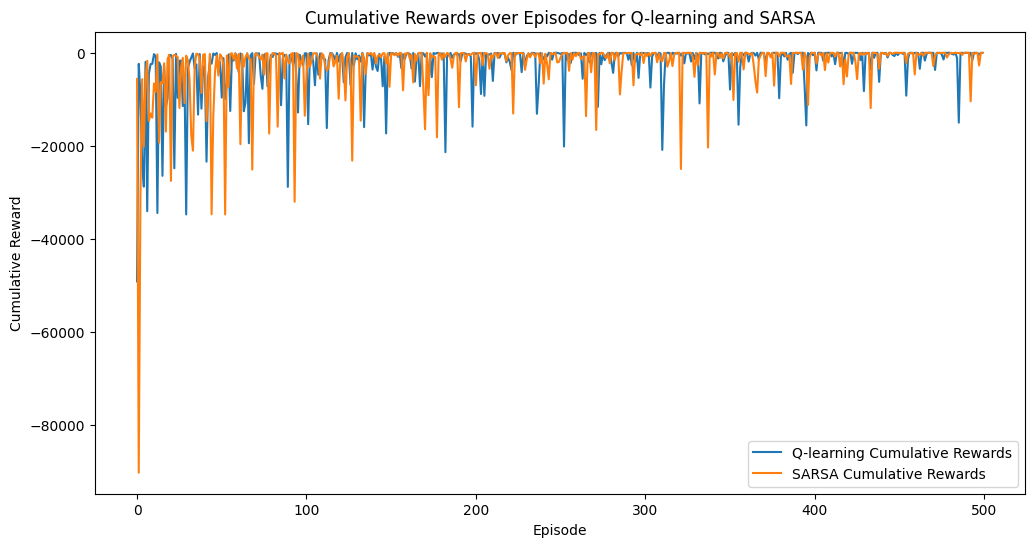

In [47]:
# Plotting cumulative rewards to compare convergence rates (for Q-learning and SARSA)
plt.figure(figsize=(12, 6))
plt.plot(rewards_qlearning, label="Q-learning Cumulative Rewards")
plt.plot(rewards_sarsa, label="SARSA Cumulative Rewards")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.title("Cumulative Rewards over Episodes for Q-learning and SARSA")
plt.show()